# Stereoisomer testing on ChiENN - enantiomers/diastereomers (multiple centers)

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys
sys.path.append("../../../../")
from ptgnn.features.chienn.molecule3d import smiles_to_data_with_circle_index
from ptgnn.model.chienn.chienn_layer import ChiENNLayer
from ptgnn.loading.chienn_collate import collate_with_circle_index
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.transform import edge_graph_transform, vertex_graph_transform
from ptgnn.model.modules.ptree.complex_ptree_layer import ComplexPtreeLayer

## Define SMILES strings

In [2]:
smiles_list = [
    "O=C[C@](O)([H])[C@]([H])(O)CO",
    "OC[C@](O)([H])[C@]([H])(O)C=O",
    
    "O=C[C@@](O)([H])[C@]([H])(O)CO",
    "OC[C@](O)([H])[C@@]([H])(O)C=O",
    
    "O=C[C@](O)([H])[C@@]([H])(O)CO",
    "OC[C@@](O)([H])[C@]([H])(O)C=O",
    
    "O=C[C@@](O)([H])[C@@]([H])(O)CO",
    "OC[C@@](O)([H])[C@@]([H])(O)C=O",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

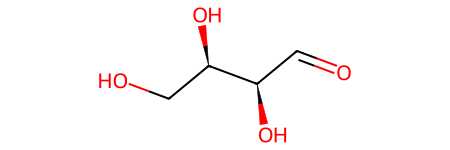

[(2, 'S'), (4, 'R')]
Bond 0 stereo: STEREONONE


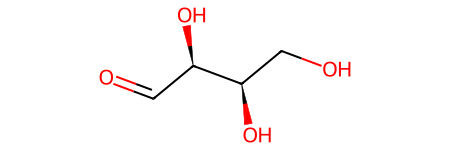

[(2, 'R'), (4, 'S')]
Bond 6 stereo: STEREONONE


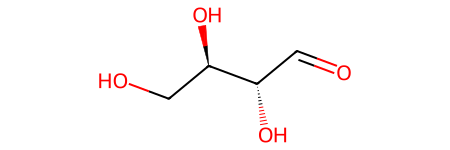

[(2, 'R'), (4, 'R')]
Bond 0 stereo: STEREONONE


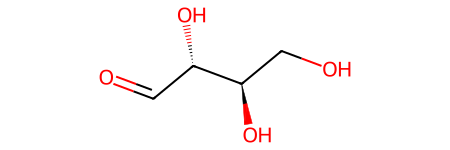

[(2, 'R'), (4, 'R')]
Bond 6 stereo: STEREONONE


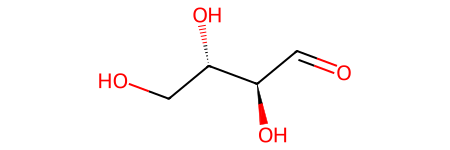

[(2, 'S'), (4, 'S')]
Bond 0 stereo: STEREONONE


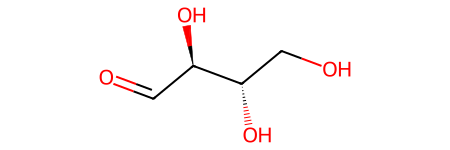

[(2, 'S'), (4, 'S')]
Bond 6 stereo: STEREONONE


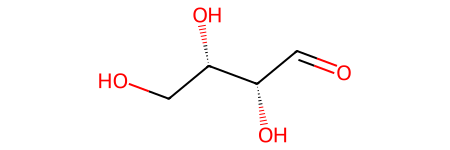

[(2, 'R'), (4, 'S')]
Bond 0 stereo: STEREONONE


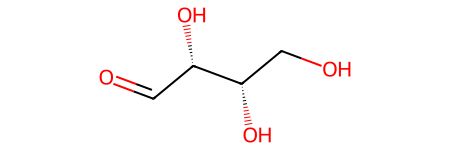

[(2, 'S'), (4, 'R')]
Bond 6 stereo: STEREONONE


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    vertex_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
d = data_list[0]
display(d.ptree, d.initial_map)
for i in range(d.num_layer):
    display(f"layer: {i}")
    display(d[f"layer{i}_order_matrix"], d[f"layer{i}_type_mask"], d[f"layer{i}_pooling"])

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  4,  9,  1,  9,  4,  1,  3,  9,  1,  4,
         3,  3,  2, 10,  4,  5, 11,  6,  2,  6, 11,  2, 11,  5,  2,  5,  6,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'layer: 0'

[[tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
           18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
           36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
           54, 55, 56, 57, 58, 59, 60, 61],
          [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
           16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
           17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)]]

[[tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
          2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]]

[[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
          10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
          38, 39, 40, 41, 42, 43, 44, 45])]]

'layer: 1'

[[tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
           -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
           36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)]]

[[tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
          1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])]]

[[tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
           9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
          22, 23, 24, 25, 26, 27, 28, 29, 30, 31])]]

'layer: 2'

[[tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
           18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
          [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
           19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
           -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
         dtype=torch.int32)]]

[[tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
          3, 3, 3, 3, 3, 3, 3, 3])]]

[[tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
           9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])]]

In [9]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[16, 43], edge_index=[2, 30], edge_attr=[30, 7], pos=[16, 3], ptree=[16], initial_map=[62], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=3, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1], layer2_order_matrix=[1], layer2_type_mask=[1], layer2_pooling=[1])
['{"S": [0, {"P": [1]}]}', '{"S": [1, {"P": [0, 2, 8]}]}', '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}', '{"S": [3, {"P": [2, 10]}]}', '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}', '{"S": [5, {"P": [4, 12]}]}', '{"S": [6, {"P": [4, 7, 13, 14]}]}', '{"S": [7, {"P": [6, 15]}]}', '{"S": [8, {"P": [1]}]}', '{"S": [9, {"P": [2]}]}', '{"S": [10, {"P": [3]}]}', '{"S": [11, {"P": [4]}]}', '{"S": [12, {"P": [5]}]}', '{"S": [13, {"P": [6]}]}', '{"S": [14, {"P": [6]}]}', '{"S": [15, {"P": [7]}]}']
Data(x=[16, 43], edge_index=[2, 30], edge_attr=[30, 7], pos=[16, 3], ptree=[16], initial_map=[

## Create Model

In [10]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

model = AdvancedPermutationTreeLayer(
    hidden_dim=43,
    k=k
)

In [11]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=43,
        k=k
    ))
    for _ in range(2)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=43,
        k=k
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=43, out_features=43, bias=False)
      (p_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=43, out_features=43, bias=False)
      )
      (z_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=43, out_features=43, bias=False)
      )
      (s_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (elu): ELU(alpha=1.0)
      (batch_norm): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=43, out_features=43, bias=False)
      (p_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Li

## Create batches

In [12]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [13]:
for idx, batch in enumerate(batch_list):
    display(f"Batch: {idx}")
    display(batch.ptree)
    display(batch.initial_map)
    for layer_idx in range(batch.num_layer):
        display(f"Layer: {layer_idx}")
        display(
            batch[f"layer{layer_idx}_order_matrix"],
            batch[f"layer{layer_idx}_type_mask"],
            batch[f"layer{layer_idx}_pooling"]
        )

'Batch: 0'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  4,  9,  1,  9,  4,  1,  3,  9,  1,  4,
         3,  3,  2, 10,  4,  5, 11,  6,  2,  6, 11,  2, 11,  5,  2,  5,  6,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 1'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  4,  9,  1,  9,  4,  1,  3,  9,  1,  4,
         3,  3,  2, 10,  4,  5, 11,  6,  2,  6, 11,  2, 11,  5,  2,  5,  6,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 2'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 9, 4]}, {"Z": [1, 4, 9]}, {"Z": [1, 9, 3]}, {"Z": [1, 3, 4]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  9,  4,  1,  4,  9,  1,  9,  3,  1,  3,
         4,  3,  2, 10,  4,  5, 11,  6,  2,  6, 11,  2, 11,  5,  2,  5,  6,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 3'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 9, 4]}, {"Z": [1, 4, 9]}, {"Z": [1, 9, 3]}, {"Z": [1, 3, 4]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 11, 6]}, {"Z": [2, 6, 11]}, {"Z": [2, 11, 5]}, {"Z": [2, 5, 6]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  9,  4,  1,  4,  9,  1,  9,  3,  1,  3,
         4,  3,  2, 10,  4,  5, 11,  6,  2,  6, 11,  2, 11,  5,  2,  5,  6,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 4'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 6, 11]}, {"Z": [2, 11, 6]}, {"Z": [2, 5, 11]}, {"Z": [2, 6, 5]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  4,  9,  1,  9,  4,  1,  3,  9,  1,  4,
         3,  3,  2, 10,  4,  5,  6, 11,  2, 11,  6,  2,  5, 11,  2,  6,  5,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 5'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 4, 9]}, {"Z": [1, 9, 4]}, {"Z": [1, 3, 9]}, {"Z": [1, 4, 3]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 6, 11]}, {"Z": [2, 11, 6]}, {"Z": [2, 5, 11]}, {"Z": [2, 6, 5]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  4,  9,  1,  9,  4,  1,  3,  9,  1,  4,
         3,  3,  2, 10,  4,  5,  6, 11,  2, 11,  6,  2,  5, 11,  2,  6,  5,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 6'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 9, 4]}, {"Z": [1, 4, 9]}, {"Z": [1, 9, 3]}, {"Z": [1, 3, 4]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 6, 11]}, {"Z": [2, 11, 6]}, {"Z": [2, 5, 11]}, {"Z": [2, 6, 5]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  9,  4,  1,  4,  9,  1,  9,  3,  1,  3,
         4,  3,  2, 10,  4,  5,  6, 11,  2, 11,  6,  2,  5, 11,  2,  6,  5,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

'Batch: 7'

['{"S": [0, {"P": [1]}]}',
 '{"S": [1, {"P": [0, 2, 8]}]}',
 '{"S": [2, {"P": [{"Z": [3, 9, 4]}, {"Z": [1, 4, 9]}, {"Z": [1, 9, 3]}, {"Z": [1, 3, 4]}]}]}',
 '{"S": [3, {"P": [2, 10]}]}',
 '{"S": [4, {"P": [{"Z": [5, 6, 11]}, {"Z": [2, 11, 6]}, {"Z": [2, 5, 11]}, {"Z": [2, 6, 5]}]}]}',
 '{"S": [5, {"P": [4, 12]}]}',
 '{"S": [6, {"P": [4, 7, 13, 14]}]}',
 '{"S": [7, {"P": [6, 15]}]}',
 '{"S": [8, {"P": [1]}]}',
 '{"S": [9, {"P": [2]}]}',
 '{"S": [10, {"P": [3]}]}',
 '{"S": [11, {"P": [4]}]}',
 '{"S": [12, {"P": [5]}]}',
 '{"S": [13, {"P": [6]}]}',
 '{"S": [14, {"P": [6]}]}',
 '{"S": [15, {"P": [7]}]}']

tensor([ 0,  1,  1,  0,  2,  8,  2,  3,  9,  4,  1,  4,  9,  1,  9,  3,  1,  3,
         4,  3,  2, 10,  4,  5,  6, 11,  2, 11,  6,  2,  5, 11,  2,  6,  5,  5,
         4, 12,  6,  4,  7, 13, 14,  7,  6, 15,  8,  1,  9,  2, 10,  3, 11,  4,
        12,  5, 13,  6, 14,  6, 15,  7])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61],
        [-1, -1, -1, -1, -1, -1, -1,  8,  9,  7, 11, 12, 10, 14, 15, 13, 17, 18,
         16, -1, -1, -1, -1, 24, 25, 23, 27, 28, 26, 30, 31, 29, 33, 34, 32, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1,  9,  7,  8, 12, 10, 11, 15, 13, 14, 18, 16,
         17, -1, -1, -1, -1, 25, 23, 24, 28, 26, 27, 31, 29, 30, 34, 32, 33, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10,
        10, 11, 12, 13, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, -1, 11, 12, 13, 14, 15, 16, 17,
         -1, 19, 20, 21, 22, 23, 24, 25, -1, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

tensor([ 0,  1,  2,  3,  3,  3,  4,  5,  5,  5,  5,  6,  7,  7,  8,  9,  9,  9,
         9, 10, 11, 11, 12, 13, 13, 13, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

'Layer: 2'

tensor([[ 0, -1,  2, -1,  4, -1,  6, -1,  8, -1, 10, -1, 12, -1, 14, -1, 16, -1,
         18, -1, 20, -1, 22, -1, 24, -1, 26, -1, 28, -1, 30, -1],
        [ 1, -1,  3, -1,  5, -1,  7, -1,  9, -1, 11, -1, 13, -1, 15, -1, 17, -1,
         19, -1, 21, -1, 23, -1, 25, -1, 27, -1, 29, -1, 31, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
         9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15])

In [14]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

## Put batches through model

In [15]:
out_list = [
    model(batch)
    for batch in batch_list
]

In [16]:
out_list

[tensor([[ 1.0934e-03,  4.5741e-03, -1.4012e-02,  1.3250e-02, -1.6850e-02,
          -2.5067e-03,  1.6716e-02, -1.0157e-02, -1.0962e-02, -1.3649e-02,
           4.9725e-04,  3.5770e-03, -8.6991e-03,  8.1822e-04, -2.1907e-03,
          -6.7275e-03, -4.4231e-03, -9.3192e-04,  5.1648e-03, -7.1452e-03,
           1.2709e-02,  1.6067e-02, -1.6253e-03,  1.2930e-02, -8.8419e-03,
           4.8820e-03, -9.5298e-03,  4.2362e-04, -2.0271e-02, -5.7932e-03,
          -5.0579e-03, -1.2574e-02, -1.6641e-02, -6.9944e-03,  1.3118e-02,
           8.4986e-03,  3.7250e-05,  1.3268e-02, -1.5565e-03,  5.2783e-03,
           5.4215e-04,  1.0377e-02, -9.6290e-03],
         [ 1.3848e-02,  5.6370e-03, -1.3806e-02,  6.4309e-03, -1.1853e-02,
          -2.7039e-02,  3.2140e-02, -1.2074e-02, -2.8692e-02, -2.8611e-02,
          -1.7893e-03,  1.9133e-02, -1.3652e-02, -4.1654e-03, -4.6775e-02,
          -2.9978e-02, -2.1672e-02,  1.3145e-02, -1.2043e-02, -1.2388e-02,
           3.2607e-02,  2.8298e-02, -4.4311e-02,  

## Compare batches

In [17]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True,  True, False, False, False, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True,  True]])

In [18]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True,  True, False, False, False, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False,  True,  True]])

In [19]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0.        , 0.        , 0.01812422, 0.01812422, 0.00491103,
        0.00491103, 0.01842576, 0.01842576],
       [0.        , 0.        , 0.01812422, 0.01812422, 0.00491103,
        0.00491103, 0.01842576, 0.01842576],
       [0.01812422, 0.01812422, 0.        , 0.        , 0.02112948,
        0.02112948, 0.00491459, 0.00491459],
       [0.01812422, 0.01812422, 0.        , 0.        , 0.02112948,
        0.02112948, 0.00491459, 0.00491459],
       [0.00491103, 0.00491103, 0.02112948, 0.02112948, 0.        ,
        0.        , 0.01811274, 0.01811274],
       [0.00491103, 0.00491103, 0.02112948, 0.02112948, 0.        ,
        0.        , 0.01811274, 0.01811274],
       [0.01842576, 0.01842576, 0.00491459, 0.00491459, 0.01811274,
        0.01811274, 0.        , 0.        ],
       [0.01842576, 0.01842576, 0.00491459, 0.00491459, 0.01811274,
        0.01811274, 0.        , 0.        ]], dtype=float32)

Does not distinguish properly. Similar behavior to observation in edge graph when attempting novel tree structure to establish invariance to enantiomers. Can be solved to the depicted state by increasing number of layers